# Final Proect

This notebook gives an introduction to working with the various data sets in [Wikipedia
Talk](https://figshare.com/projects/Wikipedia_Talk/16731) project on Figshare. The release includes:

1. a large historical corpus of discussion comments on Wikipedia talk pages
2. a sample of over 100k comments with human labels for whether the comment contains a personal attack
3. a sample of over 100k comments with human labels for whether the comment has aggressive tone

Please refer to our [wiki](https://meta.wikimedia.org/wiki/Research:Detox/Data_Release) for documentation of the schema of each data set and our [research paper](https://arxiv.org/abs/1610.08914) for documentation on the data collection and modeling methodology. 

In this notebook we show how to build a simple classifier for detecting personal attacks and apply the classifier to a random sample of the comment corpus to see whether discussions on user pages have more personal attacks than discussion on article pages.

### clean up comments dataset

In [284]:
import string
import pandas as pd
import urllib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
color = sns.color_palette()
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, log_loss
from sklearn.preprocessing import StandardScaler

In [286]:
# download annotated comments and annotations
import requests

ANNOTATED_COMMENTS_URL = 'https://ndownloader.figshare.com/files/7554634' 
ANNOTATIONS_URL = 'https://ndownloader.figshare.com/files/7554637' 

ANNOTATED_COMMENTS = requests.get(ANNOTATED_COMMENTS_URL, allow_redirects=True)
ANNOTATIONS = requests.get(ANNOTATIONS_URL, allow_redirects=True)

open('dataset/attack_annotated_comments.tsv', 'wb').write(ANNOTATED_COMMENTS.content)
open('dataset/attack_annotations.tsv', 'wb').write(ANNOTATIONS.content)

In [232]:
comments = pd.read_csv('dataset/attack_annotated_comments.tsv', sep = '\t', index_col = 0)
annotations = pd.read_csv('dataset/attack_annotations.tsv',  sep = '\t')

In [233]:
comments.sample(3)

,comment,year,logged_in,ns,sample,split
rev_id,,,,,,
514740298,`NEWLINE_TOKENNEWLINE_TOKEN== Formally ==NEWLI...,2012,True,article,random,test
684888872,"NEWLINE_TOKENNEWLINE_TOKEN== TPB, you keep swa...",2015,False,user,random,test
238659374,`NEWLINE_TOKENNEWLINE_TOKEN== Hi #2 ==NEWLINE_...,2008,True,user,random,train


In [234]:
len(annotations['rev_id'].unique())

115864

In [235]:
annotations.sample(3)

,rev_id,worker_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
1097755,506975725,3475,0.0,0.0,1.0,0.0,1.0
85640,38547793,2511,0.0,1.0,0.0,0.0,1.0
355124,132470088,1809,0.0,0.0,0.0,0.0,0.0


In [236]:
# labels a comment as an atack if the majority of annoatators did so
labels = annotations.groupby('rev_id')['attack'].mean() > 0.5

In [237]:
labels.sample(3)

rev_id
191626532    False
501285205    False
579085456     True
Name: attack, dtype: bool

In [238]:
# join labels and comments
comments['attack'] = labels

In [260]:
# remove newline and tab tokens
comments['comment'] = comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace(string.punctuation, " "))

In [278]:
comments.to_csv('dataset/clearn_up_comments.csv')

In [279]:
comments = pd.read_csv('dataset/clearn_up_comments.csv')

In [254]:
# df = comments
# di = {'False' : 0, 'True' : 1}
# df = df.replace('attack', di)

In [280]:
comments.count()

rev_id       115864
comment      115864
year         115864
logged_in    115864
ns           115864
sample       115864
split        115864
attack       115864
dtype: int64

In [262]:
comments.sample(3)

,comment,year,logged_in,ns,sample,split,attack
rev_id,,,,,,,
430999925,` == Personal Attacks == I made no personal ...,2011,True,user,blocked,train,False
269744391,`::This sentence is accurate then: approach or...,2009,True,article,blocked,dev,False
271836187,== atheists and philosophy == so are atheists...,2009,False,article,blocked,train,False


In [263]:
# query with boolean expression
comments.query('attack')['logged_in'].count()

13590

In [264]:
logout = comments[comments.logged_in == False]
print(logout.count())
out_a = comments[comments.attack == True]
print(out_a.count())

comment      30946
year         30946
logged_in    30946
ns           30946
sample       30946
split        30946
attack       30946
dtype: int64
comment      13590
year         13590
logged_in    13590
ns           13590
sample       13590
split        13590
attack       13590
dtype: int64


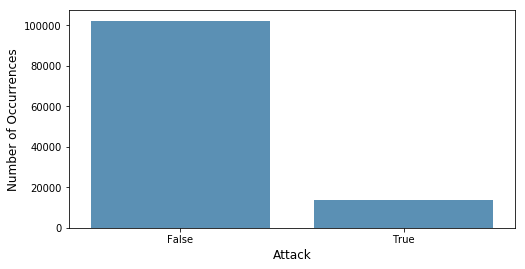

In [265]:
attack_level = comments['attack'].value_counts()
plt.figure(figsize=(8,4))
sns.barplot(attack_level.index, attack_level.values, alpha=0.8, color=color[0])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Attack', fontsize=12)
plt.show()

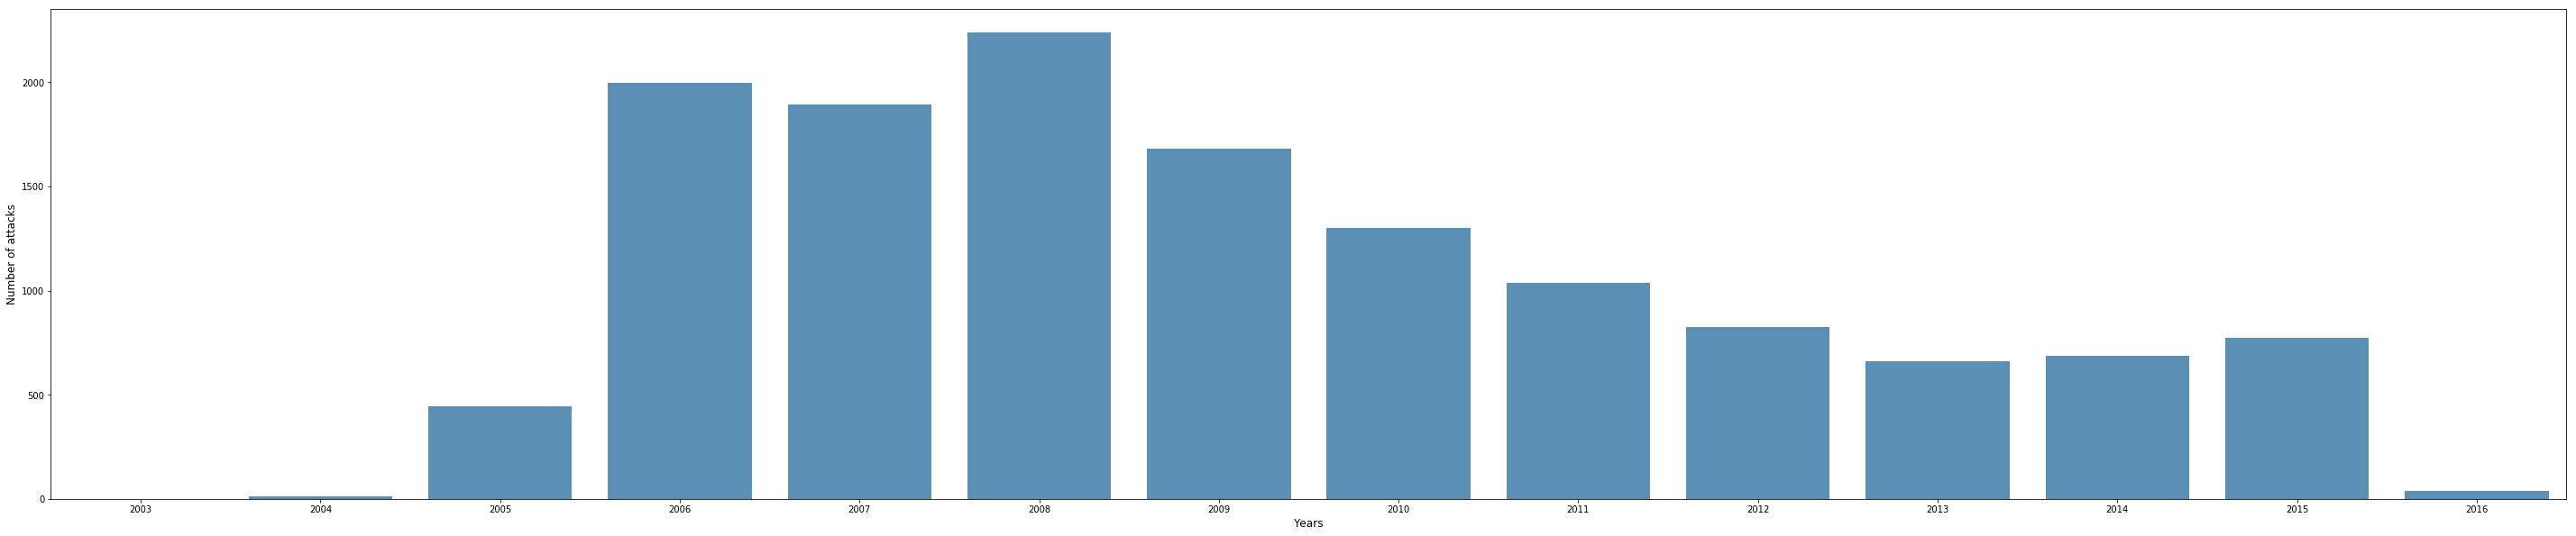

In [266]:
years = comments.query('attack').groupby('year').count()
years = years.attack
plt.figure(figsize=(50,10))
sns.barplot(years.index, years.values, alpha=0.8, color=color[0])
plt.ylabel('Number of attacks', fontsize=12)
plt.xlabel('Years', fontsize=12)
plt.show()

In [281]:
train_comments = comments.query("split=='train'")
test_comments = comments.query("split=='test'")

In [282]:
train_comments.sample(10)

,rev_id,comment,year,logged_in,ns,sample,split,attack
71892,354975794,== hey idiot == quit fucking with the sentr...,2010,False,user,blocked,train,True
85950,452555225,", 26 September 2011 (UTC) I was able to atten...",2011,True,article,random,train,False
101439,580749366,I have responded now stop wasting my time I h...,2013,True,user,blocked,train,False
46350,209469862,(forgot the Coast Guard),2008,True,article,blocked,train,False
1597,15303727,"hahaha, nice try. but they don't agree with...",2005,True,user,blocked,train,True
34152,153240838,` ::Feeling any better Fozzie? '''' `,2007,True,user,blocked,train,False
69145,337194761,"` Please do not vandalize pages, as you did ...",2010,True,user,random,train,False
26616,114791198,I believe that I have obeyed the communities...,2007,True,user,blocked,train,False
3351,23103819,"`Yet another sock check== Hi, David, are you b...",2005,True,user,random,train,False
62881,300471006,"Yes, I found some good images from USGS (too...",2009,True,article,random,train,False


## LogisticRegression

In [211]:
# fit a simple text classifier
clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', LogisticRegression()),
])
clf = clf.fit(train_comments['comment'], train_comments['attack'])
auc = roc_auc_score(test_comments['attack'], clf.predict_proba(test_comments['comment'])[:, 1])
print('Test ROC AUC: %.3f' %auc)

Test ROC AUC: 0.957


In [283]:
# clf.get_params()

## MultinomialNB

In [31]:
clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', MultinomialNB()),
])
clf = clf.fit(train_comments['comment'], train_comments['attack'])
auc = roc_auc_score(test_comments['attack'], clf.predict_proba(test_comments['comment'])[:, 1])
print('Test ROC AUC: %.3f' %auc)

Test ROC AUC: 0.936


##  RandomForestClassifier

In [33]:
clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', RandomForestClassifier()),
])
clf = clf.fit(train_comments['comment'], train_comments['attack'])
auc = roc_auc_score(test_comments['attack'], clf.predict_proba(test_comments['comment'])[:, 1])
print('Test ROC AUC: %.3f' %auc)

Test ROC AUC: 0.905


##  SVC

In [288]:
clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', LinearSVC()),
])
clf = clf.fit(train_comments['comment'], train_comments['attack'])
auc = roc_auc_score(test_comments['attack'], clf.predict_proba(test_comments['comment'])[:, 1])
print('Test ROC AUC: %.3f' %auc)

In [38]:
# train_comments[:3]
test_comments[:3]

,comment,year,logged_in,ns,sample,split,attack
rev_id,,,,,,,
155243,:If I may butt in I've spent the last 1/4 h...,2002,True,user,random,test,False
177310,On my you will find the apology that I owe...,2002,True,user,random,test,False
286174,"Yep, that's Twin cities from which this ar...",2002,True,article,random,test,False


## MLPClassifier

In [ ]:
clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', MLPClassifier()),
])
clf = clf.fit(train_comments['comment'], train_comments['attack'])
auc = roc_auc_score(test_comments['attack'], clf.predict_proba(test_comments['comment'])[:, 1])
print('Test ROC AUC: %.3f' %auc)

# Analysise

In [269]:
# correctly classify nice comment
clf.predict(['Thanks for you contribution, you did a great job!'])

array([False], dtype=bool)

In [270]:
# correctly classify nasty comment
clf.predict(['People as stupid as you should not edit Wikipedia!'])

array([ True], dtype=bool)

In [271]:
from sklearn.metrics import confusion_matrix
y_val_pred = clf.predict_proba(test_comments['comment'])
y_val = test_comments.attack
log_loss(y_val, y_val_pred)

0.15717916480915986

In [272]:
preds = clf.predict(test_comments['comment'])

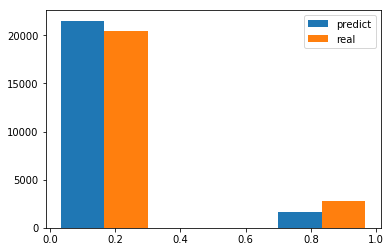

In [273]:
bins = np.linspace(0, 1, 4)
data = np.vstack([preds, y_val]).T
plt.hist(data, bins, alpha=1, label=['predict','real'])
plt.legend(loc='upper right')
plt.show()

In [274]:
from sklearn.metrics import classification_report

target_names = ['not_attack', 'attack']
print(classification_report(preds, y_val, target_names=target_names))

             precision    recall  f1-score   support

 not_attack       0.99      0.94      0.97     21516
     attack       0.55      0.91      0.69      1662

avg / total       0.96      0.94      0.95     23178



In [275]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, preds)

array([[20280,   142],
       [ 1236,  1520]])

In [276]:
print(preds[:3])
yy_val = y_val.as_matrix()

[False False False]


In [188]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

y = label_binarize(yy_val, classes=[0,1])
score = label_binarize(preds, classes=[0,1])
# # Compute Precision-Recall and plot curve
precision = dict()
recall = dict()
average_precision = dict()

for i in range(1):
    precision[i], recall[i], _ = precision_recall_curve(y[:, i], score[:, i])
    print(precision[i], recall[i], _)
    average_precision[i] = average_precision_score(y[:, i], score[:, i])
    print(average_precision[i])

(array([ 0.11890586,  0.91456077,  1.        ]), array([ 1.        ,  0.55152395,  0.        ]), array([0, 1]))
0.55772859665


In [190]:
y[:, 0]

array([0, 0, 0, ..., 0, 0, 0])

In [184]:
# Plot Precision-Recall curve for each class
from itertools import cycle
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue'])
precision["micro"], recall["micro"], _ = precision_recall_curve(y.ravel(),score.ravel())
average_precision["micro"] = average_precision_score(y, score,average="micro")


plt.clf()
plt.plot(recall["micro"], precision["micro"], color='red', lw=2,
         label='micro-average Precision-recall curve (area = {0:0.2f})'
               ''.format(average_precision["micro"]))
for i, color in zip(range(len(target_names)), colors):
    print(recall[i], precision[i], color)
    print(target_names[i], average_precision[i])
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='Precision-recall curve of class {0} (area = {1:0.2f})'
                   ''.format(target_names[i], average_precision[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(loc="lower right")
plt.show()

(array([ 1.        ,  0.55152395,  0.        ]), array([ 0.11890586,  0.91456077,  1.        ]), 'navy')
('not_attack', 0.55772859664985908)


KeyError: 1

In [181]:
average_precision['micro']


0.55772859664985908

In [ ]:
from sklearn.metrics import roc_curve, auc
import pandas as pd
from scipy import interp

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
labels = ['high','medium','low']
colors = ['red', 'blue', 'green', 'yellow']

for i in range(3):
    fpr, tpr, _ = roc_curve(y[:,i], score[:,i])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, color=colors[i],
             label='ROC %s (area = %0.2f)' % (labels[i], roc_auc))

mean_tpr /= 3
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='yellow', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

###  PART TWO

In [ ]:
import os
import re
import requests
from scipy.stats import bernoulli
% matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import tarfile

# download and untar data

USER_TALK_CORPUS_2004_URL = 'https://ndownloader.figshare.com/files/6982061'
ARTICLE_TALK_CORPUS_2004_URL = 'https://ndownloader.figshare.com/files/7038050'

USER_TALK_CORPUS_2004_r = requests.get(USER_TALK_CORPUS_2004_URL, allow_redirects=True)
ARTICLE_TALK_CORPUS_2004_r = requests.get(ARTICLE_TALK_CORPUS_2004_URL, allow_redirects=True)

open('dataset/comments_user_2004.tar.gz', 'wb').write(USER_TALK_CORPUS_2004_r.content)
open('dataset/comments_article_2004.tar.gz', 'wb').write(ARTICLE_TALK_CORPUS_2004_r.content)

# download_file(USER_TALK_CORPUS_2004_URL, 'dataset/comments_user_2004.tar.gz')
# download_file(ARTICLE_TALK_CORPUS_2004_URL,  'dataset/comments_article_2004.tar.gz')


# os.system('tar -xzf comments_user_2004.tar.gz')
# os.system('tar -xzf comments_article_2004.tar.gz')

for fname in os.listdir('dataset/'):
    if (fname.endswith(".tar.gz")):
        fname = 'dataset/' + fname
        tar = tarfile.open(fname, "r:gz")
        tar.extractall()
        tar.close()

# helper for collecting a sample of comments for a given ns and year from 
def load_no_bot_no_admin(ns, year, prob = 0.1):
    dfs = []
    
    data_dir = "dataset/comments_%s_%d" % (ns, year)
    for _, _, filenames in os.walk(data_dir):
        for filename in filenames:
            if re.match("chunk_\d*.tsv", filename):
                df = pd.read_csv(os.path.join(data_dir, filename), sep = "\t")
                df['include'] = bernoulli.rvs(prob, size=df.shape[0])
                df = df.query("bot == 0 and admin == 0 and include == 1")
                dfs.append(df)
                
    sample = pd.concat(dfs)
    sample['ns'] = ns
    sample['year'] = year
    
    return sample

df = pd.read_csv('dataset/comments_user_2004/chunk_0.tsv', sep = "\t")

df[:3]

df['include'] = bernoulli.rvs(0.1, size=df.shape[0])

df[:3]



# collect a random sample of comments from 2004 for each namespace
corpus_user = load_no_bot_no_admin('user', 2004)
corpus_article = load_no_bot_no_admin('article', 2004)
corpus = pd.concat([corpus_user, corpus_article])

corpus[:5]

# Apply model
corpus['comment'] = corpus['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
corpus['comment'] = corpus['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

corpus[:3]

corpus['attack'] = clf.predict_proba(corpus['comment'])[:,1] > 0.425 # see paper

corpus[:3]

# plot prevalence per ns

sns.pointplot(data = corpus, x = 'ns', y = 'attack')
plt.ylabel("Attack fraction")
plt.xlabel("Dicussion namespace")

#Attacks are far more prevalent in the user talk namespace.